#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Количество заказов находится в столбце 'num_orders' 

## Импортируем библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Модели

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, KFold


from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, make_scorer


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np
import itertools 
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from functools import reduce   
from scipy import stats as st

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model
from feature_engine.selection import DropCorrelatedFeatures, DropDuplicateFeatures

from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from imblearn.pipeline import make_pipeline
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

## Изучение данных

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


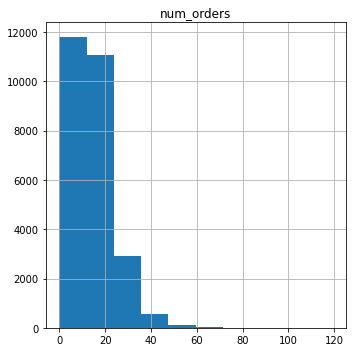

In [6]:
data.hist(figsize=(5, 5))
plt.tight_layout() 

**Выводы**
Для выполнения задачи предлагаю следующий план действий:

- Предобработать ланные
- Проанализировать тренды и сезонность
- Создать признаки
- Обучить модели

## Подготовка данных 

### Проверим индекс на упорядоченность

In [7]:
data.index.is_monotonic

True

### Проверим пропуски

In [8]:
data.isnull().sum()

num_orders    0
dtype: int64

### Проверим дубликаты

In [9]:
data.duplicated().sum() 

26415

Учитываа малое количество признаков предлагаю не считать эти поля дубликатами

**Выводы** предобработки не понадобилось приступаем к анализу данных.

## Анализ данных

In [10]:
data_copy = data.copy() 
data_copy = data_copy['2018-03':'2018-08'].resample('1H').sum()

In [11]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Тренды, Сезонность, Остаток

In [12]:
decomposed_data = seasonal_decompose(data_copy)

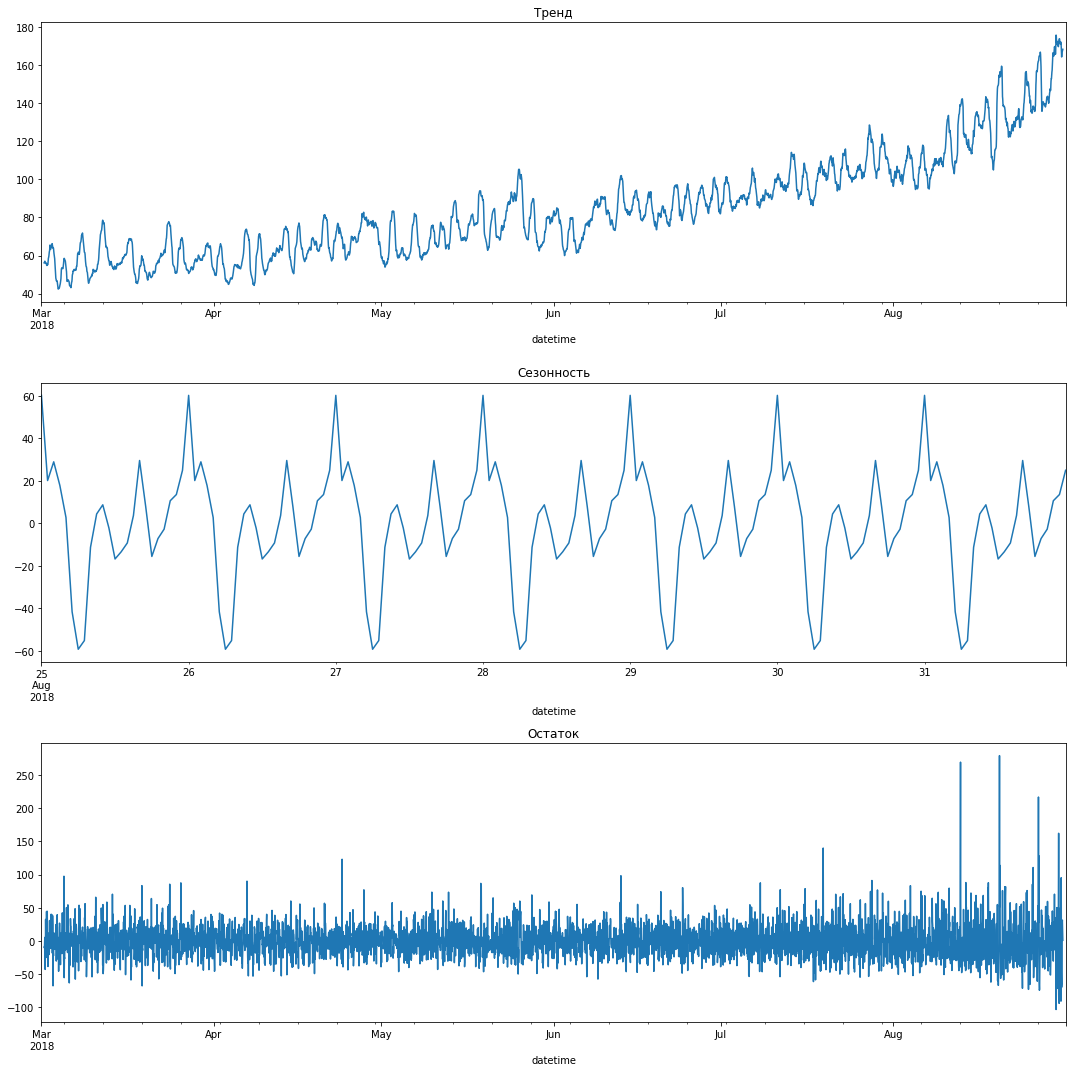

In [13]:
plt.figure(figsize=(15, 15))
plt.subplot(311)
"""
Чтобы график корректно отобразился, указываем его
оси ax, равными plt.gca() (англ. get current axis,
получить текущие оси)
"""
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed_data.seasonal.tail(24*7).plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()



**Выводы** 
Из графиков можно сделать следующие выводы:

- В общей сложности колличество заказов увеличивается на протяжении всего временого периода.
- Минимум заказов приходится на утро и растет в течении дня
- К концу лета количество заказов увеличивается

## Обучение моделей

### Создадим признаки

In [14]:
data = data.resample('1H').sum() 

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()



In [16]:
make_features(data, 10, 10)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   day_of_week   4416 non-null   int64  
 2   hour          4416 non-null   int64  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   lag_3         4413 non-null   float64
 6   lag_4         4412 non-null   float64
 7   lag_5         4411 non-null   float64
 8   lag_6         4410 non-null   float64
 9   lag_7         4409 non-null   float64
 10  lag_8         4408 non-null   float64
 11  lag_9         4407 non-null   float64
 12  lag_10        4406 non-null   float64
 13  rolling_mean  4406 non-null   float64
dtypes: float64(11), int64(3)
memory usage: 517.5 KB


### Создадим выборки

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [19]:
train.head()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


In [20]:
test.head()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,107.0
2018-08-13 15:00:00,175,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,102.9
2018-08-13 16:00:00,144,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,112.1
2018-08-13 17:00:00,152,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,119.9
2018-08-13 18:00:00,104,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,131.2


В обучающую выборку недопущенны данные "из будущего".

In [21]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

In [22]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))


Размер обучающей выборки: 3964 объектов, 13 признаков
Размер тестовой выборки: 442 объектов, 13 признаков


#### LightGBM

In [23]:
tss = TimeSeriesSplit()

In [24]:
light_gbm = LGBMRegressor()

In [25]:
params = {
          'boosting_type': ['gbdt'],
           'objective': ['regression'],
           'metric': ['rmse'],
           'learning_rate': [0.5, 0.05, 0.005]  
          
            }
grid_model_gbm = GridSearchCV(light_gbm, params, cv=tss,
                          scoring='neg_mean_absolute_error', n_jobs=-1)

grid_model_gbm.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.5, 0.05, 0.005],
                         'metric': ['rmse'], 'objective': ['regression']},
             scoring='neg_mean_absolute_error')

In [26]:
-grid_model_gbm.best_score_

19.187601608903613

In [27]:
grid_model_gbm.cv_results_

{'mean_fit_time': array([0.0856648 , 0.08146358, 0.07378993]),
 'std_fit_time': array([0.01859422, 0.02351313, 0.0159902 ]),
 'mean_score_time': array([0.00650916, 0.00550876, 0.00339565]),
 'std_score_time': array([0.00168018, 0.00024118, 0.00049472]),
 'param_boosting_type': masked_array(data=['gbdt', 'gbdt', 'gbdt'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.5, 0.05, 0.005],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_metric': masked_array(data=['rmse', 'rmse', 'rmse'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_objective': masked_array(data=['regression', 'regression', 'regression'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'boosting_type': 'gbdt',
   'learning_rate': 0.5,
   'metric': 'rmse',
   'objective

#### Catboost

In [28]:
catboost = CatBoostRegressor()

In [29]:
params = {
          'loss_function': ['RMSE'],
           'iterations': [250, 300],
           'learning_rate': [0.5, 0.05, 0.005],
           'thread_count' : [-1],
           'max_depth': [10],
           'l2_leaf_reg': [3.5]
            
        
            }
grid_model_cat = GridSearchCV(catboost, params, cv=tss,
                          scoring='neg_mean_absolute_error', n_jobs=-1)

grid_model_cat.fit(features_train, target_train)


0:	learn: 23.6528150	total: 125ms	remaining: 31.2s
1:	learn: 19.9513408	total: 158ms	remaining: 19.6s
2:	learn: 17.3902012	total: 197ms	remaining: 16.2s
3:	learn: 16.2582467	total: 225ms	remaining: 13.8s
4:	learn: 15.3318319	total: 255ms	remaining: 12.5s
5:	learn: 14.2798997	total: 288ms	remaining: 11.7s
6:	learn: 13.4777767	total: 312ms	remaining: 10.8s
7:	learn: 12.7463668	total: 341ms	remaining: 10.3s
8:	learn: 12.0407496	total: 378ms	remaining: 10.1s
9:	learn: 11.5377651	total: 413ms	remaining: 9.92s
10:	learn: 11.1401394	total: 452ms	remaining: 9.82s
11:	learn: 10.7364188	total: 495ms	remaining: 9.82s
12:	learn: 10.1751106	total: 554ms	remaining: 10.1s
13:	learn: 9.5280980	total: 584ms	remaining: 9.84s
14:	learn: 8.9363140	total: 654ms	remaining: 10.2s
15:	learn: 8.7475292	total: 704ms	remaining: 10.3s
16:	learn: 8.6843011	total: 749ms	remaining: 10.3s
17:	learn: 8.5918296	total: 786ms	remaining: 10.1s
18:	learn: 8.1092931	total: 820ms	remaining: 9.97s
19:	learn: 7.6274048	total: 

0:	learn: 25.3370696	total: 134ms	remaining: 33.3s
1:	learn: 22.5755960	total: 178ms	remaining: 22.1s
2:	learn: 20.7438128	total: 219ms	remaining: 18s
3:	learn: 19.6320005	total: 260ms	remaining: 16s
4:	learn: 18.7470552	total: 296ms	remaining: 14.5s
5:	learn: 18.0442054	total: 332ms	remaining: 13.5s
6:	learn: 17.2747811	total: 379ms	remaining: 13.2s
7:	learn: 16.6992677	total: 443ms	remaining: 13.4s
8:	learn: 16.0420419	total: 496ms	remaining: 13.3s
9:	learn: 15.7878492	total: 525ms	remaining: 12.6s
10:	learn: 15.3788843	total: 563ms	remaining: 12.2s
11:	learn: 15.1886156	total: 598ms	remaining: 11.9s
12:	learn: 14.6178760	total: 646ms	remaining: 11.8s
13:	learn: 14.4050151	total: 679ms	remaining: 11.4s
14:	learn: 14.0082689	total: 732ms	remaining: 11.5s
15:	learn: 13.5328921	total: 765ms	remaining: 11.2s
16:	learn: 13.0755161	total: 809ms	remaining: 11.1s
17:	learn: 12.7561302	total: 849ms	remaining: 10.9s
18:	learn: 12.0377908	total: 886ms	remaining: 10.8s
19:	learn: 11.7882134	tota

160:	learn: 0.3664759	total: 5.16s	remaining: 2.85s
161:	learn: 0.3563233	total: 5.18s	remaining: 2.81s
162:	learn: 0.3504454	total: 5.22s	remaining: 2.79s
163:	learn: 0.3458801	total: 5.25s	remaining: 2.75s
164:	learn: 0.3351264	total: 5.27s	remaining: 2.71s
165:	learn: 0.3217012	total: 5.28s	remaining: 2.67s
166:	learn: 0.3123261	total: 5.32s	remaining: 2.65s
167:	learn: 0.3037707	total: 5.33s	remaining: 2.6s
168:	learn: 0.3017796	total: 5.41s	remaining: 2.59s
169:	learn: 0.2952740	total: 5.44s	remaining: 2.56s
170:	learn: 0.2914907	total: 5.48s	remaining: 2.53s
171:	learn: 0.2856298	total: 5.51s	remaining: 2.5s
172:	learn: 0.2785784	total: 5.55s	remaining: 2.47s
173:	learn: 0.2736542	total: 5.59s	remaining: 2.44s
174:	learn: 0.2683040	total: 5.63s	remaining: 2.41s
175:	learn: 0.2641889	total: 5.71s	remaining: 2.4s
176:	learn: 0.2560979	total: 5.75s	remaining: 2.37s
177:	learn: 0.2471126	total: 5.79s	remaining: 2.34s
178:	learn: 0.2385339	total: 5.81s	remaining: 2.3s
179:	learn: 0.23

159:	learn: 0.8815893	total: 5.76s	remaining: 3.24s
160:	learn: 0.8675508	total: 5.8s	remaining: 3.21s
161:	learn: 0.8546642	total: 5.83s	remaining: 3.17s
162:	learn: 0.8542000	total: 5.86s	remaining: 3.13s
163:	learn: 0.8301718	total: 5.88s	remaining: 3.08s
164:	learn: 0.8185281	total: 5.93s	remaining: 3.06s
165:	learn: 0.7957115	total: 5.97s	remaining: 3.02s
166:	learn: 0.7871981	total: 5.99s	remaining: 2.98s
167:	learn: 0.7759130	total: 6.01s	remaining: 2.93s
168:	learn: 0.7632119	total: 6.04s	remaining: 2.89s
169:	learn: 0.7422887	total: 6.05s	remaining: 2.85s
170:	learn: 0.7317535	total: 6.09s	remaining: 2.81s
171:	learn: 0.7197287	total: 6.15s	remaining: 2.79s
172:	learn: 0.7000208	total: 6.2s	remaining: 2.76s
173:	learn: 0.6973879	total: 6.22s	remaining: 2.72s
174:	learn: 0.6935396	total: 6.25s	remaining: 2.68s
175:	learn: 0.6743706	total: 6.27s	remaining: 2.63s
176:	learn: 0.6634665	total: 6.3s	remaining: 2.6s
177:	learn: 0.6537936	total: 6.32s	remaining: 2.56s
178:	learn: 0.63

68:	learn: 13.3231739	total: 1.88s	remaining: 4.93s
69:	learn: 13.2414182	total: 1.93s	remaining: 4.96s
70:	learn: 13.1507493	total: 1.95s	remaining: 4.91s
71:	learn: 13.0616958	total: 1.97s	remaining: 4.88s
72:	learn: 12.9699425	total: 2.02s	remaining: 4.9s
73:	learn: 12.8773442	total: 2.04s	remaining: 4.86s
74:	learn: 12.7902736	total: 2.06s	remaining: 4.8s
75:	learn: 12.6873128	total: 2.11s	remaining: 4.83s
76:	learn: 12.6098014	total: 2.16s	remaining: 4.85s
77:	learn: 12.5317834	total: 2.18s	remaining: 4.81s
78:	learn: 12.4603442	total: 2.2s	remaining: 4.75s
79:	learn: 12.3586336	total: 2.22s	remaining: 4.72s
80:	learn: 12.2847993	total: 2.25s	remaining: 4.68s
81:	learn: 12.2287284	total: 2.29s	remaining: 4.69s
82:	learn: 12.1918021	total: 2.33s	remaining: 4.68s
83:	learn: 12.1290415	total: 2.35s	remaining: 4.65s
84:	learn: 12.0819928	total: 2.38s	remaining: 4.63s
85:	learn: 12.0402090	total: 2.41s	remaining: 4.59s
86:	learn: 11.9744726	total: 2.42s	remaining: 4.54s
87:	learn: 11.8

67:	learn: 17.0961699	total: 2.19s	remaining: 5.87s
68:	learn: 17.0703214	total: 2.25s	remaining: 5.89s
69:	learn: 17.0119625	total: 2.28s	remaining: 5.85s
70:	learn: 16.9379013	total: 2.31s	remaining: 5.83s
71:	learn: 16.8933863	total: 2.34s	remaining: 5.79s
72:	learn: 16.8077144	total: 2.37s	remaining: 5.74s
73:	learn: 16.7358793	total: 2.39s	remaining: 5.68s
74:	learn: 16.6544737	total: 2.41s	remaining: 5.63s
75:	learn: 16.6006610	total: 2.44s	remaining: 5.58s
76:	learn: 16.5348622	total: 2.47s	remaining: 5.56s
77:	learn: 16.4665545	total: 2.5s	remaining: 5.52s
78:	learn: 16.4259980	total: 2.52s	remaining: 5.47s
79:	learn: 16.3733398	total: 2.58s	remaining: 5.48s
80:	learn: 16.3232836	total: 2.61s	remaining: 5.45s
81:	learn: 16.2670179	total: 2.64s	remaining: 5.42s
82:	learn: 16.2304762	total: 2.69s	remaining: 5.41s
83:	learn: 16.1640156	total: 2.73s	remaining: 5.4s
84:	learn: 16.1139031	total: 2.77s	remaining: 5.39s
85:	learn: 16.0754367	total: 2.81s	remaining: 5.36s
86:	learn: 16.

226:	learn: 0.8917964	total: 9.35s	remaining: 948ms
227:	learn: 0.8817097	total: 9.38s	remaining: 905ms
228:	learn: 0.8707016	total: 9.43s	remaining: 864ms
229:	learn: 0.8577926	total: 9.45s	remaining: 822ms
230:	learn: 0.8468235	total: 9.53s	remaining: 784ms
231:	learn: 0.8358435	total: 9.59s	remaining: 744ms
232:	learn: 0.8223933	total: 9.62s	remaining: 702ms
233:	learn: 0.8202427	total: 9.67s	remaining: 661ms
234:	learn: 0.8135549	total: 9.72s	remaining: 621ms
235:	learn: 0.8046209	total: 9.77s	remaining: 579ms
236:	learn: 0.7965214	total: 9.81s	remaining: 538ms
237:	learn: 0.7882911	total: 9.86s	remaining: 497ms
238:	learn: 0.7835662	total: 9.91s	remaining: 456ms
239:	learn: 0.7732554	total: 9.94s	remaining: 414ms
240:	learn: 0.7592018	total: 9.96s	remaining: 372ms
241:	learn: 0.7444569	total: 9.99s	remaining: 330ms
242:	learn: 0.7354315	total: 10s	remaining: 289ms
243:	learn: 0.7305773	total: 10s	remaining: 247ms
244:	learn: 0.7236004	total: 10.1s	remaining: 206ms
245:	learn: 0.71

222:	learn: 10.9874653	total: 7.7s	remaining: 933ms
223:	learn: 10.9739007	total: 7.75s	remaining: 900ms
224:	learn: 10.9627736	total: 7.79s	remaining: 866ms
225:	learn: 10.9440405	total: 7.84s	remaining: 833ms
226:	learn: 10.9247467	total: 7.87s	remaining: 798ms
227:	learn: 10.9184728	total: 7.93s	remaining: 765ms
228:	learn: 10.9119601	total: 7.97s	remaining: 731ms
229:	learn: 10.9027930	total: 8.01s	remaining: 697ms
230:	learn: 10.8821602	total: 8.05s	remaining: 662ms
231:	learn: 10.8534720	total: 8.09s	remaining: 628ms
232:	learn: 10.8492015	total: 8.12s	remaining: 593ms
233:	learn: 10.8139582	total: 8.17s	remaining: 559ms
234:	learn: 10.7761599	total: 8.2s	remaining: 524ms
235:	learn: 10.7670753	total: 8.24s	remaining: 489ms
236:	learn: 10.7649240	total: 8.28s	remaining: 454ms
237:	learn: 10.7481473	total: 8.32s	remaining: 420ms
238:	learn: 10.7180609	total: 8.37s	remaining: 385ms
239:	learn: 10.6882002	total: 8.4s	remaining: 350ms
240:	learn: 10.6400354	total: 8.44s	remaining: 31

132:	learn: 15.1877632	total: 4.99s	remaining: 4.38s
133:	learn: 15.1367601	total: 5.02s	remaining: 4.35s
134:	learn: 15.0961567	total: 5.07s	remaining: 4.32s
135:	learn: 15.0605055	total: 5.11s	remaining: 4.28s
136:	learn: 15.0228714	total: 5.15s	remaining: 4.25s
137:	learn: 15.0060735	total: 5.21s	remaining: 4.22s
138:	learn: 14.9528716	total: 5.24s	remaining: 4.18s
139:	learn: 14.9232188	total: 5.28s	remaining: 4.15s
140:	learn: 14.9044615	total: 5.33s	remaining: 4.12s
141:	learn: 14.8841371	total: 5.37s	remaining: 4.08s
142:	learn: 14.8407940	total: 5.41s	remaining: 4.05s
143:	learn: 14.8047713	total: 5.45s	remaining: 4.01s
144:	learn: 14.7661587	total: 5.49s	remaining: 3.98s
145:	learn: 14.7366464	total: 5.52s	remaining: 3.93s
146:	learn: 14.7137497	total: 5.59s	remaining: 3.92s
147:	learn: 14.6591352	total: 5.63s	remaining: 3.88s
148:	learn: 14.6321883	total: 5.67s	remaining: 3.84s
149:	learn: 14.5770052	total: 5.71s	remaining: 3.8s
150:	learn: 14.5452821	total: 5.75s	remaining: 

130:	learn: 16.4333523	total: 5.46s	remaining: 4.96s
131:	learn: 16.3960668	total: 5.5s	remaining: 4.92s
132:	learn: 16.3595970	total: 5.55s	remaining: 4.89s
133:	learn: 16.3376997	total: 5.59s	remaining: 4.84s
134:	learn: 16.3046862	total: 5.62s	remaining: 4.79s
135:	learn: 16.2735603	total: 5.67s	remaining: 4.75s
136:	learn: 16.2483106	total: 5.7s	remaining: 4.7s
137:	learn: 16.2064588	total: 5.73s	remaining: 4.65s
138:	learn: 16.1596895	total: 5.76s	remaining: 4.6s
139:	learn: 16.1396009	total: 5.8s	remaining: 4.56s
140:	learn: 16.1083370	total: 5.82s	remaining: 4.5s
141:	learn: 16.0609226	total: 5.86s	remaining: 4.46s
142:	learn: 16.0189096	total: 5.89s	remaining: 4.41s
143:	learn: 15.9717056	total: 5.95s	remaining: 4.38s
144:	learn: 15.9207302	total: 6s	remaining: 4.34s
145:	learn: 15.9034958	total: 6.04s	remaining: 4.3s
146:	learn: 15.8539911	total: 6.09s	remaining: 4.27s
147:	learn: 15.8267210	total: 6.13s	remaining: 4.22s
148:	learn: 15.7986719	total: 6.15s	remaining: 4.17s
149

38:	learn: 30.7306682	total: 1.42s	remaining: 7.7s
39:	learn: 30.6647515	total: 1.46s	remaining: 7.64s
40:	learn: 30.6027017	total: 1.48s	remaining: 7.56s
41:	learn: 30.5431503	total: 1.52s	remaining: 7.55s
42:	learn: 30.4810084	total: 1.54s	remaining: 7.43s
43:	learn: 30.4214847	total: 1.57s	remaining: 7.36s
44:	learn: 30.3558952	total: 1.6s	remaining: 7.3s
45:	learn: 30.3047588	total: 1.64s	remaining: 7.29s
46:	learn: 30.2516694	total: 1.67s	remaining: 7.2s
47:	learn: 30.1978635	total: 1.7s	remaining: 7.17s
48:	learn: 30.1360488	total: 1.76s	remaining: 7.24s
49:	learn: 30.0792084	total: 1.8s	remaining: 7.21s
50:	learn: 30.0343651	total: 1.82s	remaining: 7.09s
51:	learn: 29.9824470	total: 1.86s	remaining: 7.07s
52:	learn: 29.9257267	total: 1.94s	remaining: 7.2s
53:	learn: 29.8760800	total: 1.97s	remaining: 7.16s
54:	learn: 29.8209812	total: 2.01s	remaining: 7.12s
55:	learn: 29.7680629	total: 2.04s	remaining: 7.07s
56:	learn: 29.7136552	total: 2.07s	remaining: 7.01s
57:	learn: 29.65780

33:	learn: 32.2867127	total: 1.24s	remaining: 7.85s
34:	learn: 32.2177174	total: 1.31s	remaining: 8.03s
35:	learn: 32.1499542	total: 1.33s	remaining: 7.92s
36:	learn: 32.0860333	total: 1.38s	remaining: 7.93s
37:	learn: 32.0166411	total: 1.41s	remaining: 7.85s
38:	learn: 31.9504670	total: 1.45s	remaining: 7.83s
39:	learn: 31.8886771	total: 1.5s	remaining: 7.85s
40:	learn: 31.8266127	total: 1.53s	remaining: 7.81s
41:	learn: 31.7653667	total: 1.57s	remaining: 7.77s
42:	learn: 31.7039112	total: 1.61s	remaining: 7.75s
43:	learn: 31.6350841	total: 1.64s	remaining: 7.68s
44:	learn: 31.5730335	total: 1.67s	remaining: 7.6s
45:	learn: 31.5125419	total: 1.7s	remaining: 7.56s
46:	learn: 31.4553248	total: 1.73s	remaining: 7.46s
47:	learn: 31.3966127	total: 1.74s	remaining: 7.34s
48:	learn: 31.3314192	total: 1.77s	remaining: 7.28s
49:	learn: 31.2668344	total: 1.81s	remaining: 7.23s
50:	learn: 31.2089189	total: 1.84s	remaining: 7.17s
51:	learn: 31.1500452	total: 1.86s	remaining: 7.1s
52:	learn: 31.09

195:	learn: 0.0148638	total: 5.93s	remaining: 3.15s
196:	learn: 0.0145534	total: 5.96s	remaining: 3.11s
197:	learn: 0.0140581	total: 5.97s	remaining: 3.08s
198:	learn: 0.0134155	total: 5.99s	remaining: 3.04s
199:	learn: 0.0124256	total: 6.01s	remaining: 3s
200:	learn: 0.0123950	total: 6.03s	remaining: 2.97s
201:	learn: 0.0119088	total: 6.04s	remaining: 2.93s
202:	learn: 0.0113432	total: 6.06s	remaining: 2.89s
203:	learn: 0.0108604	total: 6.07s	remaining: 2.86s
204:	learn: 0.0106462	total: 6.1s	remaining: 2.83s
205:	learn: 0.0105863	total: 6.13s	remaining: 2.8s
206:	learn: 0.0100533	total: 6.19s	remaining: 2.78s
207:	learn: 0.0097009	total: 6.23s	remaining: 2.75s
208:	learn: 0.0093952	total: 6.25s	remaining: 2.72s
209:	learn: 0.0093740	total: 6.29s	remaining: 2.69s
210:	learn: 0.0091897	total: 6.32s	remaining: 2.67s
211:	learn: 0.0090636	total: 6.35s	remaining: 2.63s
212:	learn: 0.0085424	total: 6.39s	remaining: 2.61s
213:	learn: 0.0083740	total: 6.42s	remaining: 2.58s
214:	learn: 0.008

189:	learn: 25.3881454	total: 7.29s	remaining: 2.3s
190:	learn: 25.3609434	total: 7.33s	remaining: 2.26s
191:	learn: 25.3322091	total: 7.37s	remaining: 2.23s
192:	learn: 25.3045034	total: 7.4s	remaining: 2.19s
193:	learn: 25.2756756	total: 7.45s	remaining: 2.15s
194:	learn: 25.2453746	total: 7.49s	remaining: 2.11s
195:	learn: 25.2203999	total: 7.53s	remaining: 2.07s
196:	learn: 25.1901158	total: 7.55s	remaining: 2.03s
197:	learn: 25.1628920	total: 7.58s	remaining: 1.99s
198:	learn: 25.1350960	total: 7.6s	remaining: 1.95s
199:	learn: 25.1078520	total: 7.64s	remaining: 1.91s
200:	learn: 25.0798135	total: 7.69s	remaining: 1.87s
201:	learn: 25.0513134	total: 7.75s	remaining: 1.84s
202:	learn: 25.0221162	total: 7.78s	remaining: 1.8s
203:	learn: 24.9947078	total: 7.81s	remaining: 1.76s
204:	learn: 24.9725837	total: 7.85s	remaining: 1.72s
205:	learn: 24.9454605	total: 7.89s	remaining: 1.69s
206:	learn: 24.9222545	total: 7.93s	remaining: 1.65s
207:	learn: 24.8929491	total: 7.96s	remaining: 1.6

102:	learn: 2.2927596	total: 3.89s	remaining: 7.45s
103:	learn: 2.2357340	total: 3.93s	remaining: 7.41s
104:	learn: 2.1911903	total: 3.95s	remaining: 7.34s
105:	learn: 2.1614096	total: 3.99s	remaining: 7.3s
106:	learn: 2.1096211	total: 4.04s	remaining: 7.29s
107:	learn: 2.0660215	total: 4.12s	remaining: 7.32s
108:	learn: 2.0241780	total: 4.17s	remaining: 7.31s
109:	learn: 1.9604805	total: 4.21s	remaining: 7.27s
110:	learn: 1.9267966	total: 4.24s	remaining: 7.21s
111:	learn: 1.8882465	total: 4.26s	remaining: 7.16s
112:	learn: 1.8293749	total: 4.31s	remaining: 7.13s
113:	learn: 1.8071634	total: 4.35s	remaining: 7.09s
114:	learn: 1.7917401	total: 4.39s	remaining: 7.06s
115:	learn: 1.7304493	total: 4.42s	remaining: 7s
116:	learn: 1.6866628	total: 4.43s	remaining: 6.94s
117:	learn: 1.6653204	total: 4.47s	remaining: 6.9s
118:	learn: 1.6440141	total: 4.5s	remaining: 6.84s
119:	learn: 1.6201338	total: 4.54s	remaining: 6.81s
120:	learn: 1.5954831	total: 4.57s	remaining: 6.75s
121:	learn: 1.5664

97:	learn: 4.2224635	total: 3.61s	remaining: 7.43s
98:	learn: 4.1441852	total: 3.65s	remaining: 7.41s
99:	learn: 4.1133318	total: 3.69s	remaining: 7.38s
100:	learn: 4.0247015	total: 3.74s	remaining: 7.36s
101:	learn: 3.9872519	total: 3.78s	remaining: 7.34s
102:	learn: 3.9578340	total: 3.81s	remaining: 7.3s
103:	learn: 3.9054859	total: 3.86s	remaining: 7.27s
104:	learn: 3.8535175	total: 3.9s	remaining: 7.24s
105:	learn: 3.7748463	total: 3.94s	remaining: 7.21s
106:	learn: 3.7543096	total: 3.98s	remaining: 7.18s
107:	learn: 3.6420474	total: 4.02s	remaining: 7.15s
108:	learn: 3.5776094	total: 4.04s	remaining: 7.08s
109:	learn: 3.5428808	total: 4.07s	remaining: 7.04s
110:	learn: 3.5392660	total: 4.12s	remaining: 7.01s
111:	learn: 3.5218322	total: 4.15s	remaining: 6.97s
112:	learn: 3.4952865	total: 4.18s	remaining: 6.92s
113:	learn: 3.4364033	total: 4.24s	remaining: 6.92s
114:	learn: 3.4296609	total: 4.28s	remaining: 6.88s
115:	learn: 3.4119104	total: 4.31s	remaining: 6.84s
116:	learn: 3.372

260:	learn: 0.1647055	total: 9.2s	remaining: 1.38s
261:	learn: 0.1642912	total: 9.24s	remaining: 1.34s
262:	learn: 0.1642025	total: 9.29s	remaining: 1.31s
263:	learn: 0.1621815	total: 9.31s	remaining: 1.27s
264:	learn: 0.1574915	total: 9.34s	remaining: 1.23s
265:	learn: 0.1557052	total: 9.37s	remaining: 1.2s
266:	learn: 0.1538093	total: 9.39s	remaining: 1.16s
267:	learn: 0.1523315	total: 9.44s	remaining: 1.13s
268:	learn: 0.1510038	total: 9.48s	remaining: 1.09s
269:	learn: 0.1465890	total: 9.53s	remaining: 1.06s
270:	learn: 0.1428545	total: 9.55s	remaining: 1.02s
271:	learn: 0.1406699	total: 9.59s	remaining: 987ms
272:	learn: 0.1377997	total: 9.62s	remaining: 952ms
273:	learn: 0.1354496	total: 9.66s	remaining: 917ms
274:	learn: 0.1334241	total: 9.68s	remaining: 880ms
275:	learn: 0.1318359	total: 9.73s	remaining: 846ms
276:	learn: 0.1296583	total: 9.76s	remaining: 811ms
277:	learn: 0.1289288	total: 9.79s	remaining: 775ms
278:	learn: 0.1269637	total: 9.82s	remaining: 740ms
279:	learn: 0.

118:	learn: 9.9727112	total: 3.57s	remaining: 5.42s
119:	learn: 9.9306116	total: 3.6s	remaining: 5.4s
120:	learn: 9.8693367	total: 3.64s	remaining: 5.39s
121:	learn: 9.8255925	total: 3.69s	remaining: 5.39s
122:	learn: 9.7681347	total: 3.73s	remaining: 5.37s
123:	learn: 9.7093845	total: 3.77s	remaining: 5.35s
124:	learn: 9.6521209	total: 3.8s	remaining: 5.32s
125:	learn: 9.5929311	total: 3.84s	remaining: 5.31s
126:	learn: 9.5281195	total: 3.87s	remaining: 5.28s
127:	learn: 9.4644493	total: 3.91s	remaining: 5.25s
128:	learn: 9.4286185	total: 3.95s	remaining: 5.24s
129:	learn: 9.3698866	total: 3.98s	remaining: 5.2s
130:	learn: 9.3171638	total: 4s	remaining: 5.16s
131:	learn: 9.2755218	total: 4.02s	remaining: 5.12s
132:	learn: 9.2295056	total: 4.03s	remaining: 5.06s
133:	learn: 9.1888341	total: 4.05s	remaining: 5.02s
134:	learn: 9.1550968	total: 4.07s	remaining: 4.98s
135:	learn: 9.1034759	total: 4.08s	remaining: 4.92s
136:	learn: 9.0659305	total: 4.1s	remaining: 4.87s
137:	learn: 9.035330

117:	learn: 12.4859899	total: 3.85s	remaining: 5.94s
118:	learn: 12.4457618	total: 3.9s	remaining: 5.93s
119:	learn: 12.3857376	total: 3.92s	remaining: 5.88s
120:	learn: 12.3413040	total: 3.96s	remaining: 5.85s
121:	learn: 12.2848836	total: 3.98s	remaining: 5.8s
122:	learn: 12.2487994	total: 4s	remaining: 5.76s
123:	learn: 12.2147635	total: 4.04s	remaining: 5.74s
124:	learn: 12.1462495	total: 4.13s	remaining: 5.78s
125:	learn: 12.1222318	total: 4.16s	remaining: 5.75s
126:	learn: 12.0718002	total: 4.17s	remaining: 5.68s
127:	learn: 12.0326283	total: 4.21s	remaining: 5.66s
128:	learn: 11.9930141	total: 4.24s	remaining: 5.61s
129:	learn: 11.9436211	total: 4.3s	remaining: 5.62s
130:	learn: 11.9013312	total: 4.33s	remaining: 5.59s
131:	learn: 11.8515133	total: 4.41s	remaining: 5.61s
132:	learn: 11.8156440	total: 4.44s	remaining: 5.57s
133:	learn: 11.7927138	total: 4.46s	remaining: 5.53s
134:	learn: 11.7734972	total: 4.49s	remaining: 5.48s
135:	learn: 11.7078015	total: 4.52s	remaining: 5.45s

276:	learn: 5.2838336	total: 7.85s	remaining: 652ms
277:	learn: 5.2650758	total: 7.88s	remaining: 624ms
278:	learn: 5.2293513	total: 7.91s	remaining: 595ms
279:	learn: 5.1948147	total: 7.95s	remaining: 568ms
280:	learn: 5.1667453	total: 7.97s	remaining: 539ms
281:	learn: 5.1422136	total: 7.99s	remaining: 510ms
282:	learn: 5.1282622	total: 8.02s	remaining: 482ms
283:	learn: 5.0968787	total: 8.06s	remaining: 454ms
284:	learn: 5.0777237	total: 8.11s	remaining: 427ms
285:	learn: 5.0675684	total: 8.14s	remaining: 399ms
286:	learn: 5.0516106	total: 8.18s	remaining: 370ms
287:	learn: 5.0397103	total: 8.22s	remaining: 342ms
288:	learn: 5.0127278	total: 8.23s	remaining: 313ms
289:	learn: 4.9923723	total: 8.26s	remaining: 285ms
290:	learn: 4.9666924	total: 8.31s	remaining: 257ms
291:	learn: 4.9595357	total: 8.32s	remaining: 228ms
292:	learn: 4.9353568	total: 8.37s	remaining: 200ms
293:	learn: 4.9281805	total: 8.41s	remaining: 172ms
294:	learn: 4.8961811	total: 8.44s	remaining: 143ms
295:	learn: 

274:	learn: 7.7877312	total: 9.63s	remaining: 876ms
275:	learn: 7.7384629	total: 9.68s	remaining: 842ms
276:	learn: 7.7291190	total: 9.72s	remaining: 807ms
277:	learn: 7.7093291	total: 9.76s	remaining: 772ms
278:	learn: 7.7069227	total: 9.79s	remaining: 737ms
279:	learn: 7.6686605	total: 9.83s	remaining: 702ms
280:	learn: 7.6611841	total: 9.87s	remaining: 667ms
281:	learn: 7.6328974	total: 9.92s	remaining: 633ms
282:	learn: 7.6063149	total: 9.95s	remaining: 598ms
283:	learn: 7.5901398	total: 9.99s	remaining: 563ms
284:	learn: 7.5679753	total: 10s	remaining: 528ms
285:	learn: 7.5609303	total: 10.1s	remaining: 493ms
286:	learn: 7.5344023	total: 10.1s	remaining: 458ms
287:	learn: 7.4971500	total: 10.1s	remaining: 422ms
288:	learn: 7.4885542	total: 10.2s	remaining: 387ms
289:	learn: 7.4575277	total: 10.2s	remaining: 352ms
290:	learn: 7.4344157	total: 10.2s	remaining: 317ms
291:	learn: 7.4117522	total: 10.3s	remaining: 282ms
292:	learn: 7.3817226	total: 10.3s	remaining: 247ms
293:	learn: 7.

133:	learn: 16.3376997	total: 5.88s	remaining: 7.29s
134:	learn: 16.3046862	total: 5.92s	remaining: 7.23s
135:	learn: 16.2735603	total: 5.97s	remaining: 7.2s
136:	learn: 16.2483106	total: 6.02s	remaining: 7.16s
137:	learn: 16.2064588	total: 6.06s	remaining: 7.12s
138:	learn: 16.1596895	total: 6.08s	remaining: 7.04s
139:	learn: 16.1396009	total: 6.12s	remaining: 7s
140:	learn: 16.1083370	total: 6.14s	remaining: 6.93s
141:	learn: 16.0609226	total: 6.17s	remaining: 6.87s
142:	learn: 16.0189096	total: 6.23s	remaining: 6.84s
143:	learn: 15.9717056	total: 6.28s	remaining: 6.8s
144:	learn: 15.9207302	total: 6.33s	remaining: 6.77s
145:	learn: 15.9034958	total: 6.36s	remaining: 6.71s
146:	learn: 15.8539911	total: 6.4s	remaining: 6.67s
147:	learn: 15.8267210	total: 6.46s	remaining: 6.63s
148:	learn: 15.7986719	total: 6.48s	remaining: 6.57s
149:	learn: 15.7764186	total: 6.52s	remaining: 6.52s
150:	learn: 15.7458741	total: 6.57s	remaining: 6.48s
151:	learn: 15.6946442	total: 6.61s	remaining: 6.43s

131:	learn: 23.1263918	total: 3.88s	remaining: 4.94s
132:	learn: 23.0898965	total: 3.9s	remaining: 4.9s
133:	learn: 23.0559345	total: 3.92s	remaining: 4.85s
134:	learn: 23.0231955	total: 3.93s	remaining: 4.81s
135:	learn: 22.9852567	total: 3.97s	remaining: 4.79s
136:	learn: 22.9538217	total: 3.98s	remaining: 4.74s
137:	learn: 22.9195712	total: 4.01s	remaining: 4.71s
138:	learn: 22.8849712	total: 4.06s	remaining: 4.7s
139:	learn: 22.8516667	total: 4.08s	remaining: 4.67s
140:	learn: 22.8176521	total: 4.12s	remaining: 4.64s
141:	learn: 22.7818169	total: 4.16s	remaining: 4.62s
142:	learn: 22.7481830	total: 4.19s	remaining: 4.6s
143:	learn: 22.7092187	total: 4.22s	remaining: 4.58s
144:	learn: 22.6707794	total: 4.26s	remaining: 4.56s
145:	learn: 22.6347760	total: 4.3s	remaining: 4.54s
146:	learn: 22.5991253	total: 4.32s	remaining: 4.5s
147:	learn: 22.5594953	total: 4.34s	remaining: 4.46s
148:	learn: 22.5265703	total: 4.36s	remaining: 4.42s
149:	learn: 22.4939759	total: 4.4s	remaining: 4.4s
1

125:	learn: 25.6285234	total: 4.24s	remaining: 5.86s
126:	learn: 25.5890747	total: 4.26s	remaining: 5.81s
127:	learn: 25.5540344	total: 4.29s	remaining: 5.76s
128:	learn: 25.5171058	total: 4.34s	remaining: 5.75s
129:	learn: 25.4822845	total: 4.36s	remaining: 5.71s
130:	learn: 25.4447271	total: 4.42s	remaining: 5.7s
131:	learn: 25.4141268	total: 4.44s	remaining: 5.65s
132:	learn: 25.3828843	total: 4.47s	remaining: 5.61s
133:	learn: 25.3512901	total: 4.5s	remaining: 5.58s
134:	learn: 25.3152738	total: 4.52s	remaining: 5.53s
135:	learn: 25.2763579	total: 4.55s	remaining: 5.49s
136:	learn: 25.2397226	total: 4.56s	remaining: 5.43s
137:	learn: 25.2012953	total: 4.6s	remaining: 5.4s
138:	learn: 25.1648939	total: 4.63s	remaining: 5.36s
139:	learn: 25.1335259	total: 4.66s	remaining: 5.33s
140:	learn: 25.0989102	total: 4.72s	remaining: 5.32s
141:	learn: 25.0692701	total: 4.77s	remaining: 5.31s
142:	learn: 25.0371081	total: 4.81s	remaining: 5.28s
143:	learn: 24.9955767	total: 4.85s	remaining: 5.2

286:	learn: 18.7332831	total: 8.49s	remaining: 385ms
287:	learn: 18.7081018	total: 8.52s	remaining: 355ms
288:	learn: 18.6846936	total: 8.56s	remaining: 326ms
289:	learn: 18.6612044	total: 8.57s	remaining: 296ms
290:	learn: 18.6432984	total: 8.6s	remaining: 266ms
291:	learn: 18.6208339	total: 8.63s	remaining: 236ms
292:	learn: 18.5973459	total: 8.66s	remaining: 207ms
293:	learn: 18.5725151	total: 8.7s	remaining: 178ms
294:	learn: 18.5563722	total: 8.73s	remaining: 148ms
295:	learn: 18.5360733	total: 8.78s	remaining: 119ms
296:	learn: 18.5141087	total: 8.8s	remaining: 88.9ms
297:	learn: 18.4949117	total: 8.84s	remaining: 59.3ms
298:	learn: 18.4748403	total: 8.87s	remaining: 29.7ms
299:	learn: 18.4589409	total: 8.89s	remaining: 0us
0:	learn: 34.6937344	total: 62.3ms	remaining: 18.6s
1:	learn: 34.6148842	total: 97.8ms	remaining: 14.6s
2:	learn: 34.5492080	total: 132ms	remaining: 13s
3:	learn: 34.4719343	total: 175ms	remaining: 13s
4:	learn: 34.3923825	total: 201ms	remaining: 11.8s
5:	lear

6:	learn: 33.4161512	total: 157ms	remaining: 6.57s
7:	learn: 32.7313609	total: 170ms	remaining: 6.2s
8:	learn: 32.0768683	total: 181ms	remaining: 5.85s
9:	learn: 31.4729490	total: 191ms	remaining: 5.53s
10:	learn: 30.9478737	total: 202ms	remaining: 5.3s
11:	learn: 30.4780715	total: 212ms	remaining: 5.08s
12:	learn: 29.9956592	total: 217ms	remaining: 4.79s
13:	learn: 29.5462067	total: 227ms	remaining: 4.64s
14:	learn: 29.0980946	total: 238ms	remaining: 4.52s
15:	learn: 28.6921890	total: 249ms	remaining: 4.42s
16:	learn: 28.3417525	total: 260ms	remaining: 4.32s
17:	learn: 27.9935120	total: 271ms	remaining: 4.24s
18:	learn: 27.6479825	total: 281ms	remaining: 4.16s
19:	learn: 27.3071174	total: 292ms	remaining: 4.09s
20:	learn: 27.0383746	total: 303ms	remaining: 4.02s
21:	learn: 26.7646949	total: 313ms	remaining: 3.96s
22:	learn: 26.4961456	total: 323ms	remaining: 3.89s
23:	learn: 26.2481810	total: 334ms	remaining: 3.84s
24:	learn: 25.9935144	total: 344ms	remaining: 3.79s
25:	learn: 25.7546

163:	learn: 18.0191295	total: 1.82s	remaining: 1.51s
164:	learn: 18.0034059	total: 1.83s	remaining: 1.5s
165:	learn: 17.9948996	total: 1.84s	remaining: 1.49s
166:	learn: 17.9738571	total: 1.85s	remaining: 1.47s
167:	learn: 17.9525016	total: 1.86s	remaining: 1.46s
168:	learn: 17.8957723	total: 1.87s	remaining: 1.45s
169:	learn: 17.8553337	total: 1.89s	remaining: 1.44s
170:	learn: 17.7996401	total: 1.9s	remaining: 1.43s
171:	learn: 17.7857535	total: 1.91s	remaining: 1.42s
172:	learn: 17.7760079	total: 1.92s	remaining: 1.41s
173:	learn: 17.7747545	total: 1.93s	remaining: 1.4s
174:	learn: 17.7416836	total: 1.94s	remaining: 1.39s
175:	learn: 17.7309258	total: 1.95s	remaining: 1.38s
176:	learn: 17.7265225	total: 1.96s	remaining: 1.36s
177:	learn: 17.6938102	total: 1.97s	remaining: 1.35s
178:	learn: 17.6493908	total: 1.98s	remaining: 1.34s
179:	learn: 17.6197851	total: 1.99s	remaining: 1.33s
180:	learn: 17.5895327	total: 2s	remaining: 1.32s
181:	learn: 17.5869927	total: 2.01s	remaining: 1.31s

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f38093c2230>,
             n_jobs=-1,
             param_grid={'iterations': [250, 300], 'l2_leaf_reg': [3.5],
                         'learning_rate': [0.5, 0.05, 0.005],
                         'loss_function': ['RMSE'], 'max_depth': [10],
                         'thread_count': [-1]},
             scoring='neg_mean_absolute_error')

In [30]:
-grid_model_cat.best_score_

19.4725472229398

In [31]:
grid_model_cat.cv_results_

{'mean_fit_time': array([ 8.87612886,  9.09526291,  8.64645948, 10.42202945, 10.9599596 ,
         8.57088089]),
 'std_fit_time': array([1.14093146, 0.79538459, 0.76663979, 0.92711449, 1.21639041,
        0.94853742]),
 'mean_score_time': array([0.01793041, 0.01217608, 0.00856643, 0.01610932, 0.01428638,
        0.01276302]),
 'std_score_time': array([0.00967675, 0.00575236, 0.00835302, 0.01277432, 0.00557873,
        0.00934233]),
 'param_iterations': masked_array(data=[250, 250, 250, 300, 300, 300],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_l2_leaf_reg': masked_array(data=[3.5, 3.5, 3.5, 3.5, 3.5, 3.5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.5, 0.05, 0.005, 0.5, 0.05, 0.005],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=objec

#### LinearRegression

In [32]:
linreg = LinearRegression()

In [33]:
params = {
          'fit_intercept': [True, False],
           'copy_X': [True, False]
    
          
            }

grid_model_regr = GridSearchCV(linreg, params, cv=tss,
                          scoring='neg_mean_absolute_error', n_jobs=-1)

grid_model_regr.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

In [34]:
-grid_model_regr.best_score_

25.30627493225336

In [35]:
grid_model_regr.cv_results_

{'mean_fit_time': array([0.00427423, 0.00452328, 0.00446434, 0.00277719]),
 'std_fit_time': array([0.00085061, 0.00162234, 0.0025243 , 0.00068873]),
 'mean_score_time': array([0.00163074, 0.00149107, 0.00211997, 0.00111427]),
 'std_score_time': array([8.02727279e-05, 7.03746061e-05, 1.55110911e-03, 3.21654095e-04]),
 'param_copy_X': masked_array(data=[True, True, False, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, False, True, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'copy_X': True, 'fit_intercept': True},
  {'copy_X': True, 'fit_intercept': False},
  {'copy_X': False, 'fit_intercept': True},
  {'copy_X': False, 'fit_intercept': False}],
 'split0_test_score': array([-21.53855422, -21.93868075, -21.53855422, -21.93868075]),
 'split1_test_score': array([-23.2000246 , -23.36690341, -23.2000246 , -2

**Выводы** Лучшую метрику на тренировочной выборке показала модель LightGBM

### Проверка лучшей модели на тестовой выборке 

In [36]:
gbm_preds_test =  grid_model_gbm.best_estimator_.predict(features_test)
gbm_rmse_test = mean_squared_error(target_test, gbm_preds_test, squared=False)
gbm_rmse_test

45.003858878419074

**Вывод** RMSE модели LightGBM на тестовой выборке 45.003858878419074. Это проходит по требованиям.

## Общий вывод

В ходе работы над проектом был произведен анализ данных, общего тренда, сезонной цикличности и остатков. Удалось сделать следующие выводы:

- В общей сложности колличество заказов увеличивается на протяжении всего временого периода.
- Минимум заказов приходится на утро и растет в течении дня
- К концу лета количество заказов увеличивается

При помощи функции созданны дополнительные признаки На дополненном наборе данных обучены следующие модели:

- LightGBM
- Catboost
- LinearRegression

В ходе тестирования лучшей моделью была выбрана LightGBM. Ее RMSE на тестовой выборке 45.003858878419074, что подходит под требования.
